In [47]:
# Importing Libraries

import requests
from bs4 import BeautifulSoup
import pandas as pd

# Define the initial URL and headers
base_url = "https://www.booking.com/searchresults.en-gb.html"
params = {
    'ss': 'United States',
    'ssne': 'United States',
    'ssne_untouched': 'United States',
    'efdco': 1,
    'label': 'gen173nr-1BCAEoggI46AdIM1gEaKcBiAEBmAEJuAEXyAEM2AEB6AEBiAIBqAIDuAKW18W1BsACAdICJDUzZDY1M2JjLWUzMmUtNDUzNy1iYTRlLWQ1YTE5OWY5NWU1NdgCBeACAQ',
    'sid': '47e61d0859026259a0ff04b6d3ad19ec',
    'aid': 304142,
    'lang': 'en-gb',
    'sb': 1,
    'src_elem': 'sb',
    'src': 'searchresults',
    'dest_id': 224,
    'dest_type': 'country',
    'checkin': '2024-12-21',
    'checkout': '2025-03-21',
    'group_adults': 1,
    'no_rooms': 1,
    'group_children': 0,
    'selected_currency': 'USD',
    # 'rows': 100  # Number of rows
}

headers = {
    'User-Agent': 'Mozilla/5.0 (X11; CrOS x86_64 8172.45.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.64 Safari/537.36',
    'Accept-Language': 'en-US, en;q=0.5'
}

# Function to get hotel data
def get_hotel_data(soup):
    hotels = soup.findAll('div', {'data-testid': 'property-card'})
    hotels_data = []
    for hotel in hotels:
        # Extract the hotel name
        name_element = hotel.find('div', {'data-testid': 'title'})
        name = name_element.text.strip() if name_element else None

        # Extract the hotel location
        location_element = hotel.find('span', {'data-testid': 'address'})
        location = location_element.text.strip() if location_element else None

        # Extract the hotel price
        price_element = hotel.find('span', {'data-testid': 'price-and-discounted-price'})
        price = price_element.text.strip() if price_element else None

        # Append hotels_data with info about hotel
        hotels_data.append({
            'name': name,
            'location': location,
            'price': price
        })
    return hotels_data


all_hotels_data = []

# Initial request
response = requests.get(base_url, headers=headers, params=params)
soup = BeautifulSoup(response.content, 'html.parser')
all_hotels_data.extend(get_hotel_data(soup))


# Convert to DataFrame
df_hotel = pd.DataFrame(all_hotels_data)

# Save DataFrame to CSV
df_hotel.to_csv('us_hotel_prices.csv', index=False)

print("Data has been saved to 'us_hotel_prices.csv'")


Data has been saved to 'us_hotel_prices.csv'


Top 5 Cheapest States by Average Hotel Price:
                    state    price
9                New York   6495.0
10  Northwest Territories   9495.0
8              New Mexico   9576.0
7                  Nevada  12850.0
12                   Utah  14172.5


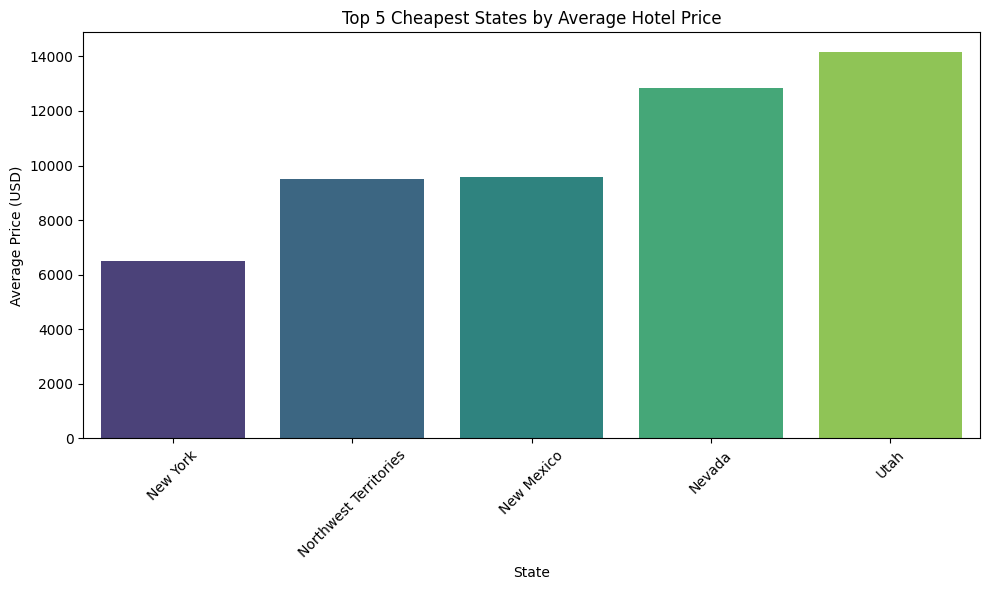

In [55]:
from geopy.geocoders import Nominatim
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize geolocator
geolocator = Nominatim(user_agent="hotel_price_analysis")

def get_state_from_location(location):
    try:
        location_info = geolocator.geocode(location, addressdetails=True)
        if location_info and 'state' in location_info.raw['address']:
            return location_info.raw['address']['state']
    except Exception as e:
        print(f"Error geocoding {location}: {e}")
    return None


df = df_hotel.copy()

# Extract states from locations
df['state'] = df['location'].apply(get_state_from_location)

# Function to clean the price column
def clean_currency(x):
    """ If the value is a string, then remove currency symbol and delimiters
    otherwise, the value is numeric and can be converted
    """
    if isinstance(x, str):
        return(x.replace('$', '').replace(',', '').replace('US', ''))
    return(x)

df['price'] = df['price'].apply(clean_currency).astype('float')


# Calculate average price per state
state_prices = df.groupby('state')['price'].mean().reset_index()

# Sort states by average price
state_prices_sorted = state_prices.sort_values(by='price')

# Get the top 5 cheapest states
top_5_cheapest_states = state_prices_sorted.head(5)

# Display the top 5 cheapest states in a table
print("Top 5 Cheapest States by Average Hotel Price:")
print(top_5_cheapest_states)

# Plot the top 5 cheapest states
plt.figure(figsize=(10, 6))
sns.barplot(data=top_5_cheapest_states, x='state', y='price', palette='viridis')
plt.title('Top 5 Cheapest States by Average Hotel Price')
plt.xlabel('State')
plt.ylabel('Average Price (USD)')
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot
plt.savefig('top_5_cheapest_states.png')

# Show the plot
plt.show()